In [1]:
from pathlib import Path

import matplotlib
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.text as mtext
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [2]:
DATA_ROOT = Path('..') / 'data'

In [3]:
dfs = []
activity_labels = ['bed', 'chair', 'lying', 'ambulating']
default_names = ['time', 'front', 'vertical', 'lateral', 'sensor_id', 'rssi', 'phase', 'frequency', 'activity']
for data_file in Path(DATA_ROOT).rglob('d[12]p??[FM]'):
    df = pd.read_csv(data_file, names=default_names)
    df['activity_label'] = df['activity'].apply(lambda i: activity_labels[i - 1])
    df['gender_label'] = str(data_file)[-1]
    df['participant'] = data_file.name
    dfs.append(df)

sensor_df = pd.concat(dfs, axis='index')
sensor_df = sensor_df.sort_values(by=['participant', 'time'])

sensor_df.to_csv('sensor_df.csv')

In [4]:
sensor_df.head()

,time,front,vertical,lateral,sensor_id,rssi,phase,frequency,activity,activity_label,gender_label,participant
0,0.00,0.27203,1.00820,-0.082102,1,-63.5,2.4252,924.25,1,bed,M,d1p01M
1,0.50,0.27203,1.00820,-0.082102,1,-63.0,4.7369,921.75,1,bed,M,d1p01M
2,1.50,0.44791,0.91636,-0.013684,1,-63.5,3.0311,923.75,1,bed,M,d1p01M
3,1.75,0.44791,0.91636,-0.013684,1,-63.0,2.0371,921.25,1,bed,M,d1p01M
4,2.50,0.34238,0.96229,-0.059296,1,-63.5,5.8920,920.25,1,bed,M,d1p01M


### Get activity boundaries
 
Now we need to get the boundaries for each activity across all the data.

In [5]:
def get_activity(df):
    first = df.iloc[0]
    last = df.iloc[-1]
    return pd.DataFrame({
        'participant': first['participant'],
        'activity': first['activity'],
        'activity_label': first['activity_label'],
        'start_time': first['time'],
        'end_time': last['time'],
        'duration': last['time'] - first['time'],
    }, index=[0])

# We join the participant name with the activity label of the row
# to get ['d1p01M-bed', 'd1p01M-bed', ...] etc.
values = sensor_df['participant'].str.cat(sensor_df['activity_label'], sep='-')

# Using shift to compare consecutive values we can obtain a boolean series
# which is `True` at the start of every activity, and `False` otherwise.
activity_start = values.shift(1) != values

# The cumsum trick converts the boolean values to integers,
# so `True` becomes `1` and `False` becomes `0`. 
# As `activity_start` is `True` at the start of every activity and `False`
# otherwise, successive activities in the data get an different (increasing)
# number:
#
#    list(pd.Series([True, False, True, True]).cumsum()) # <- [1, 1, 2, 3]
#
activity_blocks = activity_start.cumsum()

# We can now group the data by these 'blocks' and get a data frame
# with a row for each activity for each participant in time-increasing order.
activities_df = sensor_df.groupby(
    activity_blocks).apply(get_activity).reset_index(drop=True)
activities_df.head()

,participant,activity,activity_label,start_time,end_time,duration
0,d1p01M,1,bed,0.00,37.00,37.00
1,d1p01M,3,lying,37.75,74.25,36.50
2,d1p01M,1,bed,76.00,103.25,27.25
3,d1p01M,4,ambulating,104.00,111.50,7.50
4,d1p01M,2,chair,116.00,193.00,77.00


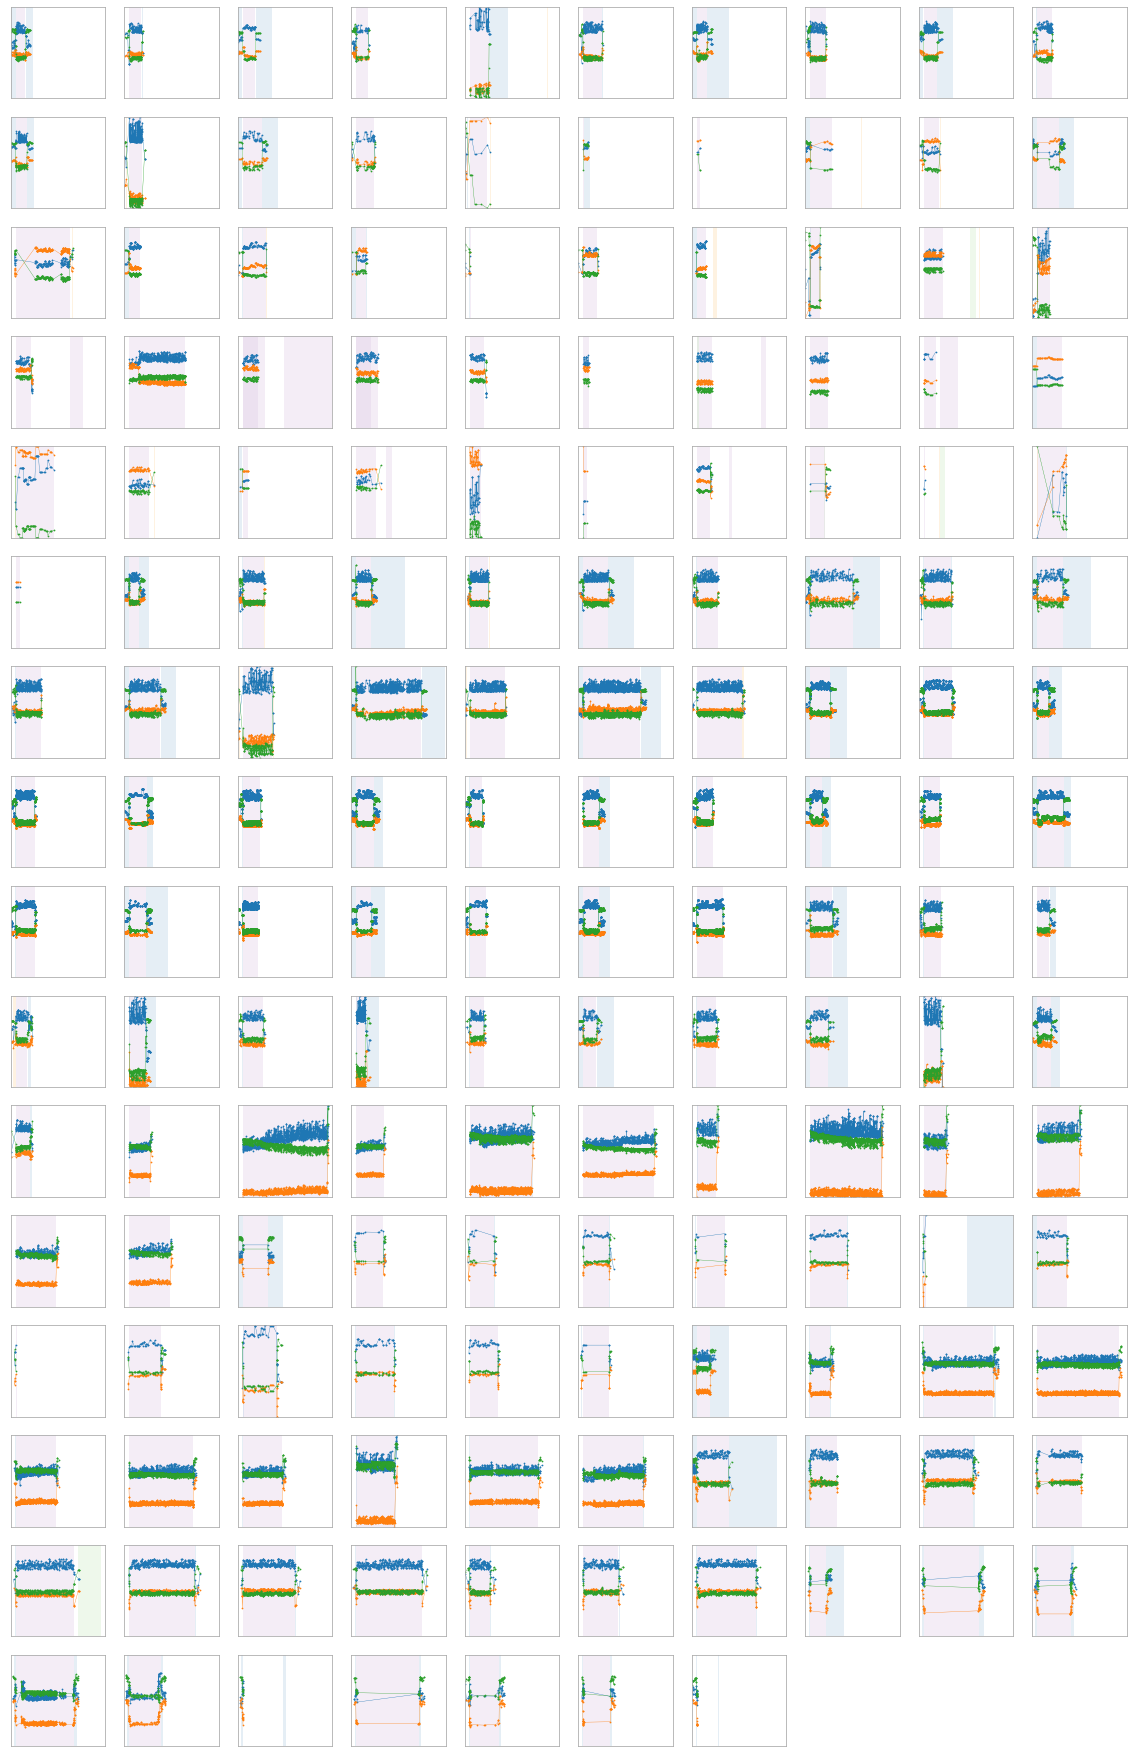

In [21]:
matplotlib.rc('axes', edgecolor='#aaaaaa')

# Rectangle colors
rect_colors = get_cmap('Pastel1').colors

# Line colors
line_colors = get_cmap('tab10').colors

# Common line options
line_opts = dict(linewidth=0.333, marker='.', markersize=1.5)

# Filter the activity data for a specific activity.
activity_label = 'lying'

activity_df = activities_df[
    activities_df['activity_label'] == activity_label]
activities = len(activity_df)

# Work out the rows and columns
ncols = 10
nrows = np.ceil(activities / ncols).astype(int)

fig = plt.figure(figsize=(ncols * 2, nrows * 2))

# We define an offset in seconds to window the data either side of an activity.
offset = 20

max_activity_duration = activity_df['duration'].max() 

sensor_columns = ['front', 'lateral', 'vertical']

for subplot, rowspec in enumerate(activity_df.iterrows()):
    
    index, row = rowspec
    participant = row['participant']
    
    ax = plt.subplot(nrows, ncols, subplot + 1)
    # Tidy the axis up a bit
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0, 0, tight=True)
    
    
    # Define time start and end times for the plotting window
    t1 = row['start_time'] - offset
    t2 = row['end_time'] + offset
   
    # Ensure axes are on the same scale
    ax.set_xlim(t1, t1 + max_activity_duration + 2 * offset)
    
    # Subset the sensor data for plotting.
    df = sensor_df[
        (sensor_df['participant'] == participant) & 
        (sensor_df['time'] >= t1) & (sensor_df['time'] <= t2)]
    
    for i, column in enumerate(sensor_columns):
        x = df['time']
        y = df[column]
        ax.plot(x, y, color=line_colors[i], **line_opts)
    
    for i in [-1, 0, 1]:
        try:
            row = activities_df.loc[index + i]
        except KeyError:
            continue
        x = row['start_time']
        ymin, ymax = -2, 2
        height = ymax - ymin
        duration = row['duration']
        if duration:
            rect = mpatches.Rectangle(
                [x, ymin], 
                duration, 
                height, 
                alpha=0.333, 
                color=rect_colors[row['activity']], 
                linewidth=0, 
                zorder=1)
            ax.add_patch(rect)
        else:
            ax.axvline(
                x, 
                ymin, 
                ymax, 
                alpha=0.333, 
                linewidth=1,
                color=rect_colors[row['activity']], 
                zorder=1)
        